In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import os
import tensorflow

ImportError: cannot import name 'pywrap_tensorflow' from 'tensorflow.python' (c:\Users\Karolina\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\__init__.py)

In [ ]:
# load the data from URL
kiwo_url = 'https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/kiwo.csv'
umsatz_url = 'https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/umsatzdaten_gekuerzt.csv'
wetter_url = 'https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/wetter.csv'

df_kiwo = pd.read_csv(kiwo_url)
df_umsatz = pd.read_csv(umsatz_url)
df_wetter = pd.read_csv(wetter_url)

# Merge df_umsatz with df_wetter on the 'date' column
df = pd.merge(df_umsatz, df_wetter, on='Datum', how='left')

# Merge the result with df_kiwo on the 'date' column
df = pd.merge(df, df_kiwo, on='Datum', how='left')

print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,id,Datum,Warengruppe,Umsatz,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,KielerWoche
0,1307011,2013-07-01,1,148.828353,6.0,17.8375,15.0,20.0,NaN
1,1307021,2013-07-02,1,159.793757,3.0,17.3125,10.0,NaN,NaN
2,1307031,2013-07-03,1,111.885594,7.0,21.0750,6.0,61.0,NaN
3,1307041,2013-07-04,1,168.864941,7.0,18.8500,7.0,20.0,NaN
4,1307051,2013-07-05,1,171.280754,5.0,19.9750,12.0,NaN,NaN


In [22]:
# Preprocess data
def prepare_data(data):
    # Convert Datum to datetime
    data['Datum'] = pd.to_datetime(data['Datum'])
    
    # Extract additional features from date
    data['DayOfWeek'] = data['Datum'].dt.dayofweek
    data['Month'] = data['Datum'].dt.month
    
    # Create 'temperatur_binned' feature
    def bin_temperature(row):
        month = row['Month']
        temperature = row['Temperatur']
        
        if month in [12, 1, 2]:  # Winter
            if temperature <= 0:
                return 'Very Cold'
            elif temperature <= 5:
                return 'Cold'
            elif temperature <= 10:
                return 'Mild'
            else:
                return 'Warm'
        elif month in [3, 4, 5]:  # Spring
            if temperature <= 10:
                return 'Cool'
            elif temperature <= 15:
                return 'Mild'
            elif temperature <= 25:
                return 'Warm'
            else:
                return 'Hot'
        elif month in [6, 7, 8]:  # Summer
            if temperature <= 15:
                return 'Cool'
            elif temperature <= 20:
                return 'Mild'
            elif temperature <= 30:
                return 'Warm'
            else:
                return 'Hot'
        else:  # Fall
            if temperature <= 10:
                return 'Cool'
            elif temperature <= 15:
                return 'Mild'
            elif temperature <= 25:
                return 'Warm'
            else:
                return 'Hot'

    data['Temperatur_binned'] = data.apply(bin_temperature, axis=1)
    
    # More robust missing value handling
    numeric_columns = ['Bewoelkung', 'Windgeschwindigkeit', 'Wettercode']
    categorical_columns = ['Warengruppe', 'Temperatur_binned']

    # Fill numeric columns with median
    for col in numeric_columns:
        data[col] = data[col].fillna(data[col].median())
    
    # Fill categorical columns with mode
    for col in categorical_columns:
        data[col] = data[col].fillna(data[col].mode()[0])
    
    # Handle KielerWoche
    data['KielerWoche'] = data['KielerWoche'].fillna(0).apply(lambda x: 1 if x != 0 else 0)

    
    return data


# Before model training, double-check for NaNs
print("Columns with NaNs:")
print(df.isna().sum())

# Prepare the data
df = prepare_data(df)

df.head()

Columns with NaNs:
id                        0
Datum                     0
Warengruppe               0
Umsatz                    0
Bewoelkung               70
Temperatur               16
Windgeschwindigkeit      16
Wettercode             2325
KielerWoche            9111
dtype: int64


,id,Datum,Warengruppe,Umsatz,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,KielerWoche,DayOfWeek,Month,Temperatur_binned
0,1307011,2013-07-01,1,148.828353,6.0,17.8375,15.0,20.0,0,0,7,Mild
1,1307021,2013-07-02,1,159.793757,3.0,17.3125,10.0,28.0,0,1,7,Mild
2,1307031,2013-07-03,1,111.885594,7.0,21.0750,6.0,61.0,0,2,7,Warm
3,1307041,2013-07-04,1,168.864941,7.0,18.8500,7.0,20.0,0,3,7,Mild
4,1307051,2013-07-05,1,171.280754,5.0,19.9750,12.0,28.0,0,4,7,Mild


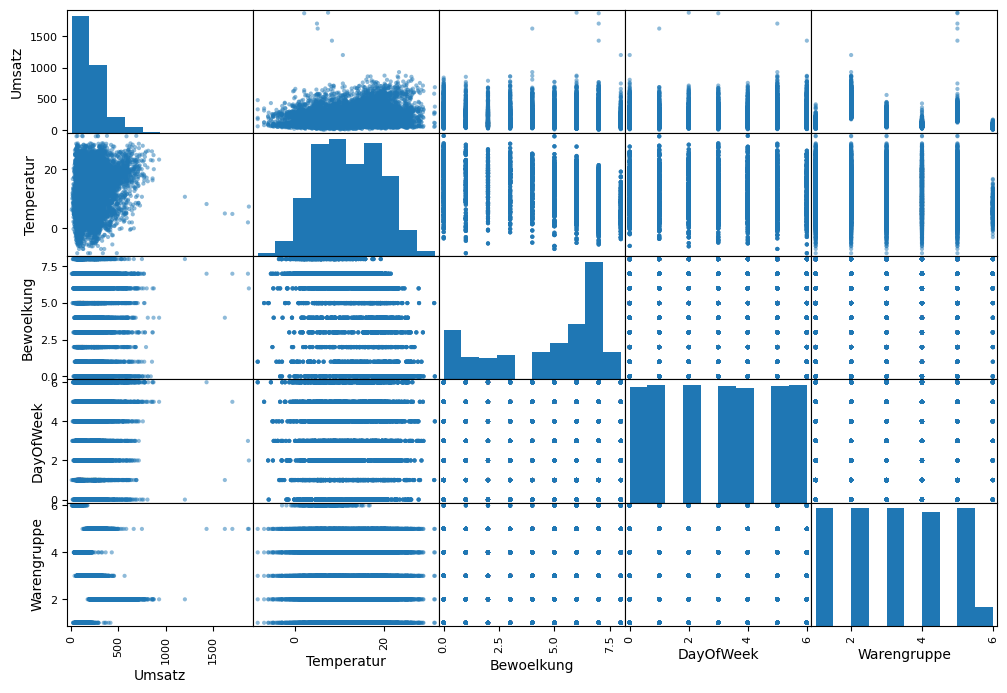

In [23]:
from pandas.plotting import scatter_matrix

# explore the data visually
attributes = ['Umsatz', 'Temperatur', 'Bewoelkung', 'DayOfWeek','Warengruppe']

scatter_matrix(df[attributes], figsize=(12,8))
plt.show()


In [ ]:
# Define categorical features
categorical_features = ['Warengruppe', 'Temperatur_binned', 'DayOfWeek', 'KielerWoche', 'Month', 'Wettercode']

# Inspect data types and unique values for categorical columns
print(df[categorical_features].dtypes)
print("Unique Values:\n",df[categorical_features].apply(lambda x: x.unique()))

# Ensure categorical columns are treated as categories
for col in categorical_features:
    df[col] = df[col].astype('category')

# Encode categorical variables using pd.get_dummies
features = pd.get_dummies(df[categorical_features], drop_first=False, dtype=int)

# Include any numeric columns that are not categorical
features['Windgeschwindigkeit'] = df['Windgeschwindigkeit']

# Construct the prepared data set including the dependent variable ('label')
prepared_data = pd.concat([df[['Umsatz']], features], axis=1)

# Handle missing values by removing rows with any missing values
prepared_data = prepared_data.dropna()

# Display the shape of the prepared data set
print(prepared_data.shape)
# Display the first few rows of the prepared data set
prepared_data.head()


Warengruppe            int64
Temperatur_binned     object
DayOfWeek              int32
KielerWoche            int64
Month                  int32
Wettercode           float64
dtype: object
Unique Values:
 Warengruppe                                         [1, 2, 3, 4, 5, 6]
Temperatur_binned             [Mild, Warm, Hot, Cool, Cold, Very Cold]
DayOfWeek                                        [0, 1, 2, 3, 4, 5, 6]
KielerWoche                                                     [0, 1]
Month                          [7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6]
Wettercode           [20.0, 28.0, 61.0, 5.0, 21.0, 65.0, 63.0, 95.0...
dtype: object
(9334, 58)


,Umsatz,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,Temperatur_binned_Cold,Temperatur_binned_Cool,Temperatur_binned_Hot,...,Wettercode_65.0,Wettercode_68.0,Wettercode_69.0,Wettercode_71.0,Wettercode_73.0,Wettercode_75.0,Wettercode_77.0,Wettercode_79.0,Wettercode_95.0,Windgeschwindigkeit
0,148.828353,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,15.0
1,159.793757,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10.0
2,111.885594,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.0
3,168.864941,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.0
4,171.280754,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12.0


In [25]:
# Set a random seed for reproducibility
np.random.seed(42)

# Shuffle the data
prepared_data = prepared_data.sample(frac=1).reset_index(drop=True)

# Calculate the number of rows for each dataset
n_total = len(prepared_data)
n_training = int(0.7 * n_total)
n_validation = int(0.20 * n_total)

# Split the features and labels for training, validation, and test
training_data = prepared_data.iloc[:n_training]
validation_data = prepared_data.iloc[n_training:n_training+n_validation]
test_data = prepared_data.iloc[n_training+n_validation:]

# Separating features and labels
training_features = training_data.drop('Umsatz', axis=1)
validation_features = validation_data.drop('Umsatz', axis=1)
test_features = test_data.drop('Umsatz', axis=1)

training_labels = training_data[['Umsatz']]
validation_labels = validation_data[['Umsatz']]
test_labels = test_data[['Umsatz']]

# Print dimensions of the dataframes
print("Training features dimensions:", training_features.shape)
print("Validation features dimensions:", validation_features.shape)
print("Test features dimensions:", test_features.shape)
print()
print("Training labels dimensions:", training_labels.shape)
print("Validation labels dimensions:", validation_labels.shape)
print("Test labels dimensions:", test_labels.shape)


Training features dimensions: (6533, 57)
Validation features dimensions: (1866, 57)
Test features dimensions: (935, 57)

Training labels dimensions: (6533, 1)
Validation labels dimensions: (1866, 1)
Test labels dimensions: (935, 1)


In [28]:
# Create subdirectory for the pickle files
subdirectory = "pickle_data"
os.makedirs(subdirectory, exist_ok=True)

# Export of the prepared data to subdirectory as pickle files
training_features.to_pickle(f"{subdirectory}/training_features.pkl")
validation_features.to_pickle(f"{subdirectory}/validation_features.pkl")
test_features.to_pickle(f"{subdirectory}/test_features.pkl")
training_labels.to_pickle(f"{subdirectory}/training_labels.pkl")
validation_labels.to_pickle(f"{subdirectory}/validation_labels.pkl")
test_labels.to_pickle(f"{subdirectory}/test_labels.pkl")

In [29]:

# Import the necessary libraries
import pandas as pd

# Define the file paths
subdirectory = "pickle_data"
training_features_path = f"{subdirectory}/training_features.pkl"
validation_features_path = f"{subdirectory}/validation_features.pkl"
test_features_path = f"{subdirectory}/test_features.pkl"
training_labels_path = f"{subdirectory}/training_labels.pkl"
validation_labels_path = f"{subdirectory}/validation_labels.pkl"
test_labels_path = f"{subdirectory}/test_labels.pkl"

# Read the pickle files
training_features = pd.read_pickle(training_features_path)
validation_features = pd.read_pickle(validation_features_path)
test_features = pd.read_pickle(test_features_path)
training_labels = pd.read_pickle(training_labels_path)
validation_labels = pd.read_pickle(validation_labels_path)
test_labels = pd.read_pickle(test_labels_path)

# Verify the loaded data by printing their shapes and a few rows
print("Loaded Training features dimensions:", training_features.shape)
print("Loaded Validation features dimensions:", validation_features.shape)
print("Loaded Test features dimensions:", test_features.shape)
print()
print("Loaded Training labels dimensions:", training_labels.shape)
print("Loaded Validation labels dimensions:", validation_labels.shape)
print("Loaded Test labels dimensions:", test_labels.shape)
print()

print("First few rows of loaded training features:")
print(training_features.head())
print()
print("First few rows of loaded training labels:")
print(training_labels.head())


Loaded Training features dimensions: (6533, 57)
Loaded Validation features dimensions: (1866, 57)
Loaded Test features dimensions: (935, 57)

Loaded Training labels dimensions: (6533, 1)
Loaded Validation labels dimensions: (1866, 1)
Loaded Test labels dimensions: (935, 1)

First few rows of loaded training features:
   Warengruppe_1  Warengruppe_2  Warengruppe_3  Warengruppe_4  Warengruppe_5  \
0              0              0              1              0              0   
1              0              0              0              1              0   
2              0              0              1              0              0   
3              0              1              0              0              0   
4              0              0              0              0              1   

   Warengruppe_6  Temperatur_binned_Cold  Temperatur_binned_Cool  \
0              0                       0                       0   
1              0                       0                       0

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential([
  InputLayer(shape=(training_features.shape[1], )),
  BatchNormalization(),
  Dense(10, activation='relu'),
  Dense(4, activation='relu'),
  Dense(1)
])

model.summary()


ModuleNotFoundError: No module named 'tensorflow'